In [7]:
from functions_alti_simulator import *
import scipy.special as sps # function erf
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")
mpl.rcParams.update({'font.size': 18,'savefig.facecolor':'white'})

In [2]:
# X, Y : grid of wavenumbers = 2 * pi /wavelength
# steps : dkx and dky, with nx and ny values. dkx = 2*pi/(dx*nx)
# x, y : grid of real x,y : nx values with a dx step. 
noise= 0
## ---  physical surface definition
# number of x values
nx = 2*2048
nx= 2048+400
ny = 2*2048
ny = 2048+400
dx = 10 # [m]
dy = 10 # [m]

## --- read_spectra
theta_m=30
D=1000
T0=14
Hs = 4


Z1, kX, kY = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=theta_m,D=D,T0=T0,Hs=Hs,
                         sk_theta=0.001,sk_k=0.001,typeSpec='Gaussian')

# Z1, kX, kY = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=theta_m,D=D,T0=T0,
#                                       nk=1001,nth=36,klims=(0.0002,0.2),n=4,typeSpec='PM')

S1,X,Y= surface_from_Z1kxky(Z1,kX,kY) # This function contains the random operator of phases


Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  4.0


In [8]:
typeSpec='Gaussian'
if typeSpec=='Gaussian':
    print('Gaussian spectrum selected. Available options:\n Hs, sk_theta, sk_k. \n With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively \n Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m')
elif typeSpec=='PM':
    print('p')

Gaussian spectrum selected. Available options:
 Hs, sk_theta, sk_k. 
 With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m


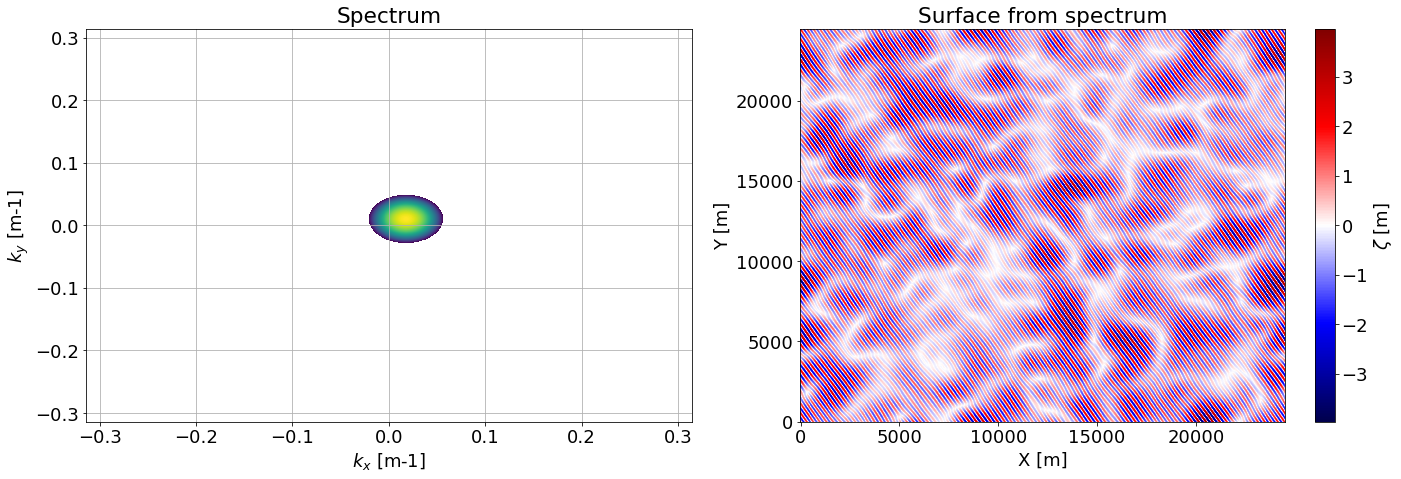

In [3]:
## ---- Plot Z1 and S1 -----------------------------------

fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=axs[0].pcolormesh(kX,kY,np.log(Z1))
_=axs[0].grid(True)
_=axs[0].set_xlabel('$k_x$ [m-1]')
_=axs[0].set_ylabel('$k_y$ [m-1]')
_=axs[0].set_title('Spectrum')

im=axs[1].pcolormesh(X,Y,S1,cmap='seismic',norm = mcolors.Normalize(vmin=S1.min(), vmax=S1.max()))
_=plt.colorbar(im,ax=axs[1],label='$\zeta$ [m]')

_=axs[1].set_xlabel('X [m]')
_=axs[1].set_ylabel('Y [m]')
_=axs[1].set_title('Surface from spectrum')
_=plt.tight_layout()

48


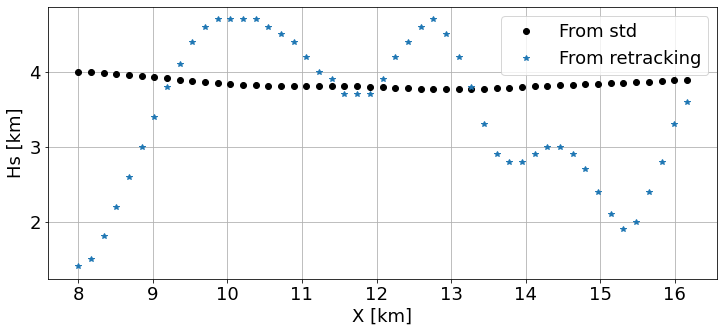

In [15]:
freq_satsampl=40 # freq for waveforms
v_sat=7000 # satellite v
alti_sat=519000 # altitude of satellite CFOSAT
radi = 8000
isplot_steps=0
# --- edges for range windows ------------
dr = 0.375
edges_max = 20

nHs=251
Hs_max = 25

wfm_ref, Hsm_ref, edges_ref = generate_wvform_database(dr,nHs,edges_max=edges_max,Hs_max=Hs_max,offset=10)

Apix = np.pi*2*alti_sat*dr / (dx**2)

# --- Norms et scalar map for plots ---------------------
normG = mcolors.Normalize(vmin=S1.min(), vmax=S1.max())
scalarMapG = cmx.ScalarMappable(norm=normG, cmap='seismic')

nxa=np.floor(radi/dx).astype(int) # size of radius of footprint in pixel
di=np.floor((v_sat/freq_satsampl)/dx).astype(int) # distance between footprint centers, in pixels (v_sat/freq_satsampl = dsitance in m)
nsamp=np.floor((nx-2*nxa)/di).astype(int) # Nb of samples

Hs_std,Hs_retrack,Xalt,waveforms = fly_over_track_v0(X,Y,S1,nsamp,nxa,di,wfm_ref,Hsm_ref,edges_ref,radi)

plt.figure(figsize=(12,5))
plt.plot(Xalt/1000,Hs_std,'ok',label='From std')
plt.plot(Xalt/1000,Hs_retrack,'*',label = 'From retracking')
plt.xlabel('X [km]')
plt.ylabel('Hs [km]')
plt.legend()
plt.grid(True)

In [ ]:
print(X.shape)
print(Y.shape)
A=None
print(A)
print(type(A)==type(None))
print(type(Hsm_ref)==type(None))

In [7]:
## -- Investigating new stuff ---------------------------------------
def fly_over_track(X,Y,S1,nsamp,nxa,di,wfm_ref,Hsm_ref,edges_ref):
    ny_mid = len(np.unique(Y))//2
    Xalt = np.zeros((nsamp,1))
    Hs_retrack = np.zeros((nsamp,1))
    Hs_std = np.zeros((nsamp,1))
    waveforms=np.zeros((nsamp,len(edges_ref)-1))

    for isamp in range(1):#nsamp):
        clear_output(wait=True)
        print(isamp)
        ialt=(nxa+isamp*di).astype(int)
        Xalt[isamp] = X[ialt]
        Xa = X - X[ialt]
        Ya = Y - Y[ny_mid]
#         surf=S1_Gaussian[ny_mid-nxa:ny_mid+nxa+1,ialt-nxa:ialt+nxa+1]*footprint
        # to have distance to satellite = range
        r=np.sqrt(Xa**2+Ya**2+(alti_sat-S1)**2)-alti_sat+10
        lim = np.sqrt(radi**2+alti_sat**2) - alti_sat +10
        r[r > lim]=np.nan
        surf = S1[np.isfinite(r)]
        plt.figure()
        plt.pcolormesh(Xa,Ya,r)
        plt.p
        
        counts,_=np.histogram(r,bins=edges_ref)
        Hs_retrack[isamp] = simple_retracking_process(counts,edges_ref,wfm_ref=wfm_ref,Hsm_ref=Hsm_ref) 
        waveforms[isamp,:]=counts
        Hs_std[isamp] = 4*np.nanstd(surf.flatten())#/np.sqrt(np.mean(footprint))
    
    return Hs_std,Hs_retrack,Xalt,waveforms

73


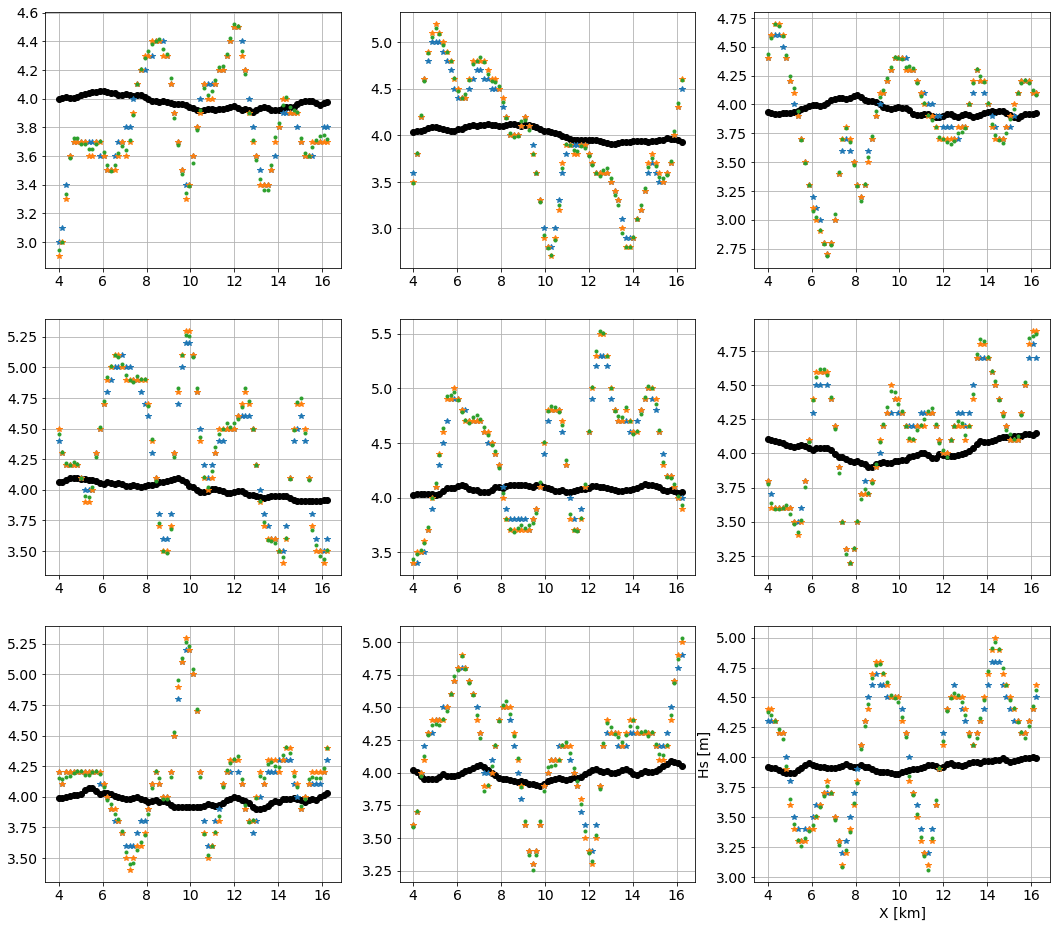

In [19]:
footprint=np.ones((2*nxa+1,2*nxa+1))
[Xa,Ya]=np.meshgrid(dx*np.arange(-nxa,nxa+1), dy*np.arange(-nxa,nxa+1))
dist_ground = (Xa**2+Ya**2)
footprint[dist_ground > radi**2]=np.nan


nbsurfk=9

# --- initialisation of Hs bases ----------------------

Hsalt=np.zeros((nsamp,nbsurfk))
Hs_retrack=np.zeros((nsamp,nbsurfk))
Hs_retrack2=np.zeros((nsamp,nbsurfk))
Hs_retrack3=np.zeros((nsamp,nbsurfk))
Xalt=np.zeros((nsamp,1))
waveforms=np.zeros((nsamp,ne-1))
wfr=np.zeros((nsamp,2))
print(nsamp)
# fig,axs = plt.subplots(10,8,figsize=(20,40))
ny_mid = (ny//2)

wfm_ref, Hsm_ref, edges = generate_wvform_database(len(edges),nHs,edges_max=edges[-1])
colors = plt.cm.seismic(np.linspace(0,1,11))
normHsref = mcolors.Normalize(vmin=0, vmax=Hsm_ref[25*10])
scalarMapHsref = cmx.ScalarMappable(norm=normHsref, cmap='seismic')

PATH = '/home/mdecarlo/PROJETS/CFOSAT_processing/ex_2/'

fig2,axs2=plt.subplots(3,3,figsize=(18,16))
for ik in range(nbsurfk):
    S1_Gaussian,X,Y= surface_from_Z1kxky(Z1_Gaussian,kX,kY)

    for isamp in range(nsamp):
        ialt=(nxa+isamp*di).astype(int)
        Xalt[isamp] = X[ialt]
        surf=S1_Gaussian[ny_mid-nxa:ny_mid+nxa+1,ialt-nxa:ialt+nxa+1]*footprint
        # to have distance to satellite = range
        r=np.sqrt(Xa**2+Ya**2+(alti_sat-surf)**2)-alti_sat+10
        r[dist_ground > radi**2]=np.nan
        counts,_=np.histogram(r,bins=edges)
        Hs_retrack[isamp,ik],dist,Hs_retrack2[isamp,ik],Hs_retrack3[isamp,ik] = simple_retracking_process(counts,edges) 
        waveforms[isamp,:]=counts
        Hsalt[isamp,ik] = 4*np.nanstd(surf.flatten())#/np.sqrt(np.mean(footprint))
    #     axs[isamp//8][isamp%8].plot(edges[:-1],wfm_ref[0,:]*Apix,'-b')
    #     axs[isamp//8][isamp%8].plot(edges[:-1],wfm_ref[-1,:]*Apix,'-r')
    #     axs[isamp//8][isamp%8].plot(edges[:-1],counts,'*')
        if ik==0:
            isplot_steps = 1
        else:
            isplot_steps = 0
        isplot_steps = 0
        if isplot_steps:
            fig,axs=plt.subplots(1,3,figsize=(18,6))
            axs[0].pcolormesh(Xa,Ya,surf,cmap='seismic',norm = normG)
            _=plt.colorbar(scalarMapG,ax=axs[0],label='surface')
            axs[0].axis('equal')

#             print('R min = ',r[np.isfinite(r)].min(), ' and R max = ',r[np.isfinite(r)].max())
            normR = mcolors.Normalize(vmin=r[np.isfinite(r)].min(), vmax=r[np.isfinite(r)].max())
            scalarMapR = cmx.ScalarMappable(norm=normR, cmap='jet')
            axs[1].pcolormesh(Xa,Ya,r,cmap='jet',norm = normR)
            _=plt.colorbar(scalarMapR,ax=axs[1],label='range')
            axs[1].axis('equal')

            for k in range(11):
                axs[2].plot(edges[:-1],wfm_ref[k*25,:]*Apix,'-',color=colors[k])
            axs[2].plot(edges[:-1],counts,'ok')
            _=plt.colorbar(scalarMapHsref,ax=axs[2],label='Hs ref [m]')
            axs[2].grid(True)
            axs[2].set_ylim((-0.5,21000))
            plt.tight_layout()

            plt.savefig(PATH+'waveform_footprint_'+f'{isamp:02d}'+'.png')
            plt.close(fig)
    #     axs[isamp//8][isamp%8].plot(Hsm_ref,dist,'*')
    #     axs[isamp//8][isamp%8].pcolormesh(Xa,Ya,surf)
    
# plt.figure(figsize=(16,6))
    axs2[ik//3,ik%3].plot(Xalt/1000,Hsalt[:,ik],'ok',label='Hs from std of surf')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack[:,ik],'*',label='Hs from min dist')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack2[:,ik],'*',label='Hs from min dist 1 iter')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack3[:,ik],'.',label='Hs from min dist 1 iter + polyfit')
    axs2[ik//3,ik%3].grid(True)
    plt.xlabel('X [km]')
    plt.ylabel('Hs [m]')
#     axs[ik//3,ik%3].legend()
plt.savefig(PATH+'Hsalt_vs_retrack_various_SGaussian_ex2.png')
# Hs_retrack25 = Hs_retrack

73


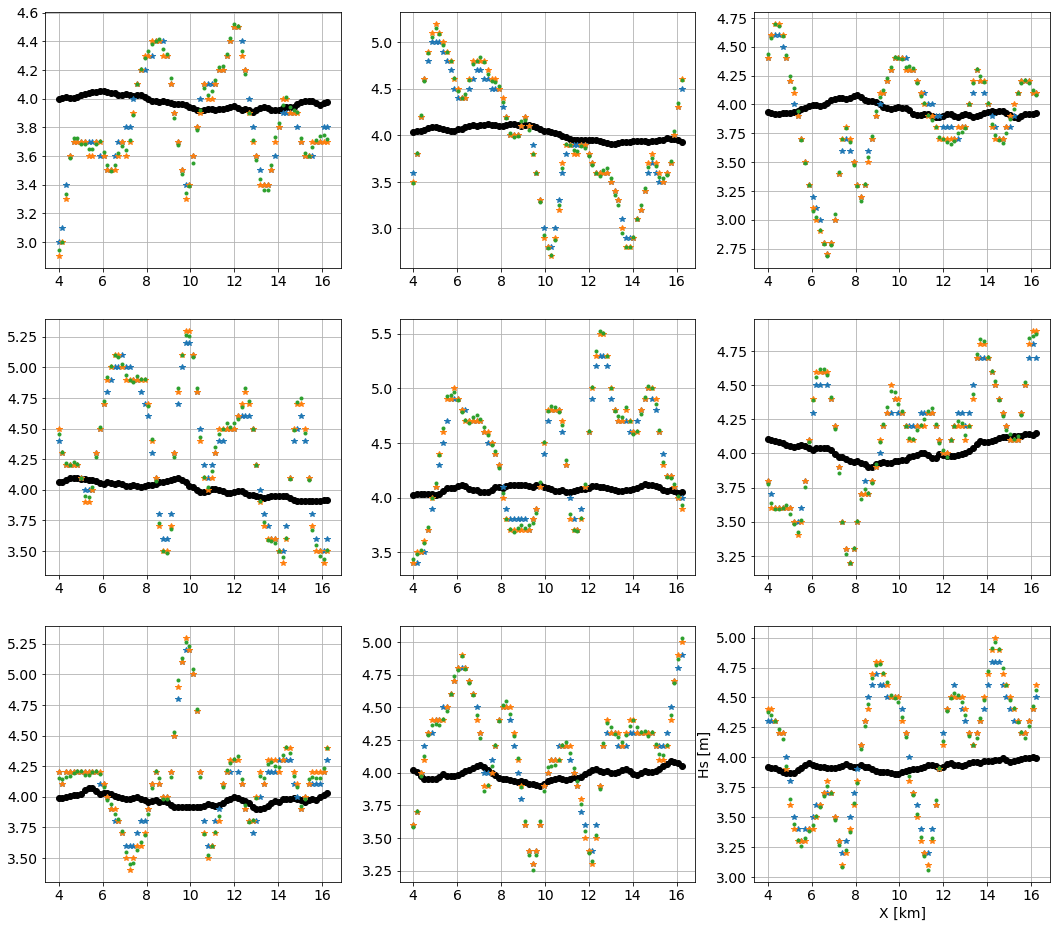

In [19]:
# OLD Version

freq_satsampl=40 # freq for waveforms
v_sat=7000 # satellite v
nsy=512
alti_sat=560000 # altitude of satellite CFOSAT

isplot_steps=0
# --- edges for range windows ------------
ne = 51
edges = np.linspace(0,20,ne)
dr = edges[1]-edges[0]
Apix = np.pi*2*alti_sat*dr / (dx**2)
# --- Hs vector --------------------------
nHs=251
Hsm = np.linspace(0,25,nHs)

normG = mcolors.Normalize(vmin=S1_Gaussian.min(), vmax=S1_Gaussian.max())
scalarMapG = cmx.ScalarMappable(norm=normG, cmap='seismic')

radi=4000   # radius of footprint
nxa=np.floor(radi/dx).astype(int) # size of radius of footprint in pixel
footprint=np.ones((2*nxa+1,2*nxa+1))
[Xa,Ya]=np.meshgrid(dx*np.arange(-nxa,nxa+1), dy*np.arange(-nxa,nxa+1))
dist_ground = (Xa**2+Ya**2)
footprint[dist_ground > radi**2]=np.nan

di=np.floor((v_sat/freq_satsampl)/dx).astype(int) # distance between footprint centers, in pixels (v_sat/freq_satsampl = dsitance in m)
nsamp=np.floor((nx-2*nxa)/di).astype(int) # Nb of samples


nbsurfk=9

# --- initialisation of Hs bases ----------------------

Hsalt=np.zeros((nsamp,nbsurfk))
Hs_retrack=np.zeros((nsamp,nbsurfk))
Hs_retrack2=np.zeros((nsamp,nbsurfk))
Hs_retrack3=np.zeros((nsamp,nbsurfk))
Xalt=np.zeros((nsamp,1))
waveforms=np.zeros((nsamp,ne-1))
wfr=np.zeros((nsamp,2))
print(nsamp)
# fig,axs = plt.subplots(10,8,figsize=(20,40))
ny_mid = (ny//2)

wfm_ref, Hsm_ref, edges = generate_wvform_database(len(edges),nHs,edges_max=edges[-1])
colors = plt.cm.seismic(np.linspace(0,1,11))
normHsref = mcolors.Normalize(vmin=0, vmax=Hsm_ref[25*10])
scalarMapHsref = cmx.ScalarMappable(norm=normHsref, cmap='seismic')

PATH = '/home/mdecarlo/PROJETS/CFOSAT_processing/ex_2/'

fig2,axs2=plt.subplots(3,3,figsize=(18,16))
for ik in range(nbsurfk):
    S1_Gaussian,X,Y= surface_from_Z1kxky(Z1_Gaussian,kX,kY)

    for isamp in range(nsamp):
        ialt=(nxa+isamp*di).astype(int)
        Xalt[isamp] = X[ialt]
        surf=S1_Gaussian[ny_mid-nxa:ny_mid+nxa+1,ialt-nxa:ialt+nxa+1]*footprint
        # to have distance to satellite = range
        r=np.sqrt(Xa**2+Ya**2+(alti_sat-surf)**2)-alti_sat+10
        r[dist_ground > radi**2]=np.nan
        counts,_=np.histogram(r,bins=edges)
        Hs_retrack[isamp,ik],dist,Hs_retrack2[isamp,ik],Hs_retrack3[isamp,ik] = simple_retracking_process(counts,edges) 
        waveforms[isamp,:]=counts
        Hsalt[isamp,ik] = 4*np.nanstd(surf.flatten())#/np.sqrt(np.mean(footprint))
    #     axs[isamp//8][isamp%8].plot(edges[:-1],wfm_ref[0,:]*Apix,'-b')
    #     axs[isamp//8][isamp%8].plot(edges[:-1],wfm_ref[-1,:]*Apix,'-r')
    #     axs[isamp//8][isamp%8].plot(edges[:-1],counts,'*')
        if ik==0:
            isplot_steps = 1
        else:
            isplot_steps = 0
        isplot_steps = 0
        if isplot_steps:
            fig,axs=plt.subplots(1,3,figsize=(18,6))
            axs[0].pcolormesh(Xa,Ya,surf,cmap='seismic',norm = normG)
            _=plt.colorbar(scalarMapG,ax=axs[0],label='surface')
            axs[0].axis('equal')

#             print('R min = ',r[np.isfinite(r)].min(), ' and R max = ',r[np.isfinite(r)].max())
            normR = mcolors.Normalize(vmin=r[np.isfinite(r)].min(), vmax=r[np.isfinite(r)].max())
            scalarMapR = cmx.ScalarMappable(norm=normR, cmap='jet')
            axs[1].pcolormesh(Xa,Ya,r,cmap='jet',norm = normR)
            _=plt.colorbar(scalarMapR,ax=axs[1],label='range')
            axs[1].axis('equal')

            for k in range(11):
                axs[2].plot(edges[:-1],wfm_ref[k*25,:]*Apix,'-',color=colors[k])
            axs[2].plot(edges[:-1],counts,'ok')
            _=plt.colorbar(scalarMapHsref,ax=axs[2],label='Hs ref [m]')
            axs[2].grid(True)
            axs[2].set_ylim((-0.5,21000))
            plt.tight_layout()

            plt.savefig(PATH+'waveform_footprint_'+f'{isamp:02d}'+'.png')
            plt.close(fig)
    #     axs[isamp//8][isamp%8].plot(Hsm_ref,dist,'*')
    #     axs[isamp//8][isamp%8].pcolormesh(Xa,Ya,surf)
    
# plt.figure(figsize=(16,6))
    axs2[ik//3,ik%3].plot(Xalt/1000,Hsalt[:,ik],'ok',label='Hs from std of surf')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack[:,ik],'*',label='Hs from min dist')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack2[:,ik],'*',label='Hs from min dist 1 iter')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack3[:,ik],'.',label='Hs from min dist 1 iter + polyfit')
    axs2[ik//3,ik%3].grid(True)
    plt.xlabel('X [km]')
    plt.ylabel('Hs [m]')
#     axs[ik//3,ik%3].legend()
plt.savefig(PATH+'Hsalt_vs_retrack_various_SGaussian_ex2.png')
# Hs_retrack25 = Hs_retrack

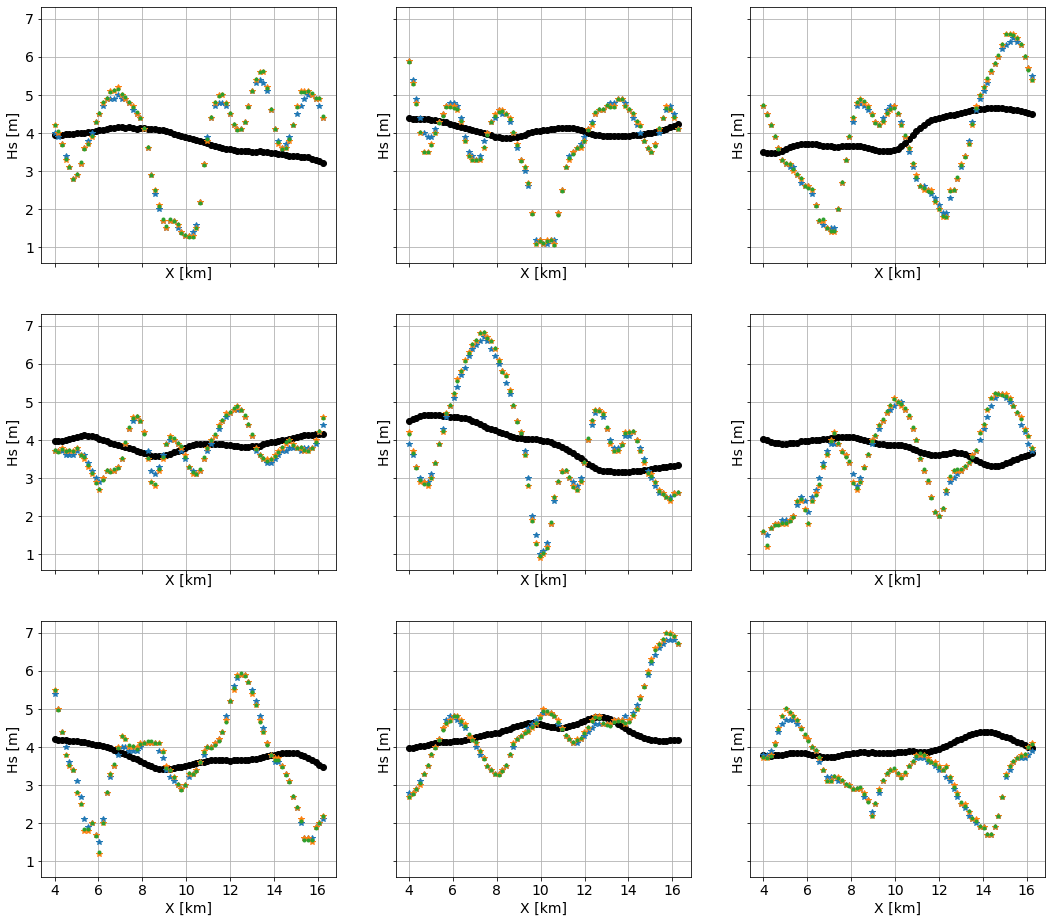

In [11]:
fig2,axs2=plt.subplots(3,3,figsize=(18,16),sharey=True,sharex=True)
for ik in range(nbsurfk):
    axs2[ik//3,ik%3].plot(Xalt/1000,Hsalt[:,ik],'ok',label='Hs from std of surf')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack[:,ik],'*',label='Hs from min dist')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack2[:,ik],'*',label='Hs from min dist 1 iter')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack3[:,ik],'.',label='Hs from min dist 1 iter + polyfit')
    axs2[ik//3,ik%3].grid(True)
    axs2[ik//3,ik%3].set_xlabel('X [km]')
    axs2[ik//3,ik%3].set_ylabel('Hs [m]')
    
plt.savefig(PATH+'Hsalt_vs_retrack_various_SGaussian2.png')

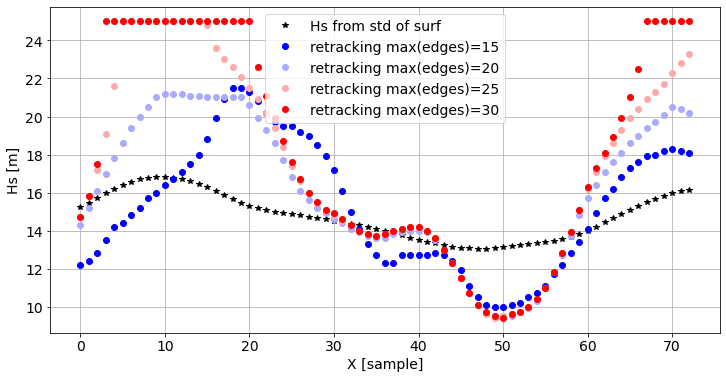

In [96]:
plt.figure(figsize=(12,6))
plt.plot(Hsalt,'*k',label='Hs from std of surf ')
colors = plt.cm.bwr(np.linspace(0,1,4))
plt.plot(Hs_retrack15,'o',color=colors[0],label='retracking max(edges)=15')
plt.plot(Hs_retrack20,'o',color=colors[1],label='retracking max(edges)=20')
plt.plot(Hs_retrack25,'o',color=colors[2],label='retracking max(edges)=25')
plt.plot(Hs_retrack30,'o',color=colors[3],label='retracking max(edges)=30')
plt.grid(True)
plt.xlabel('X [sample]')
plt.ylabel('Hs [m]')
plt.legend()
plt.savefig(PATH+'Hsalt_vs_various_retrack.png')


157549.7991537616
0.0


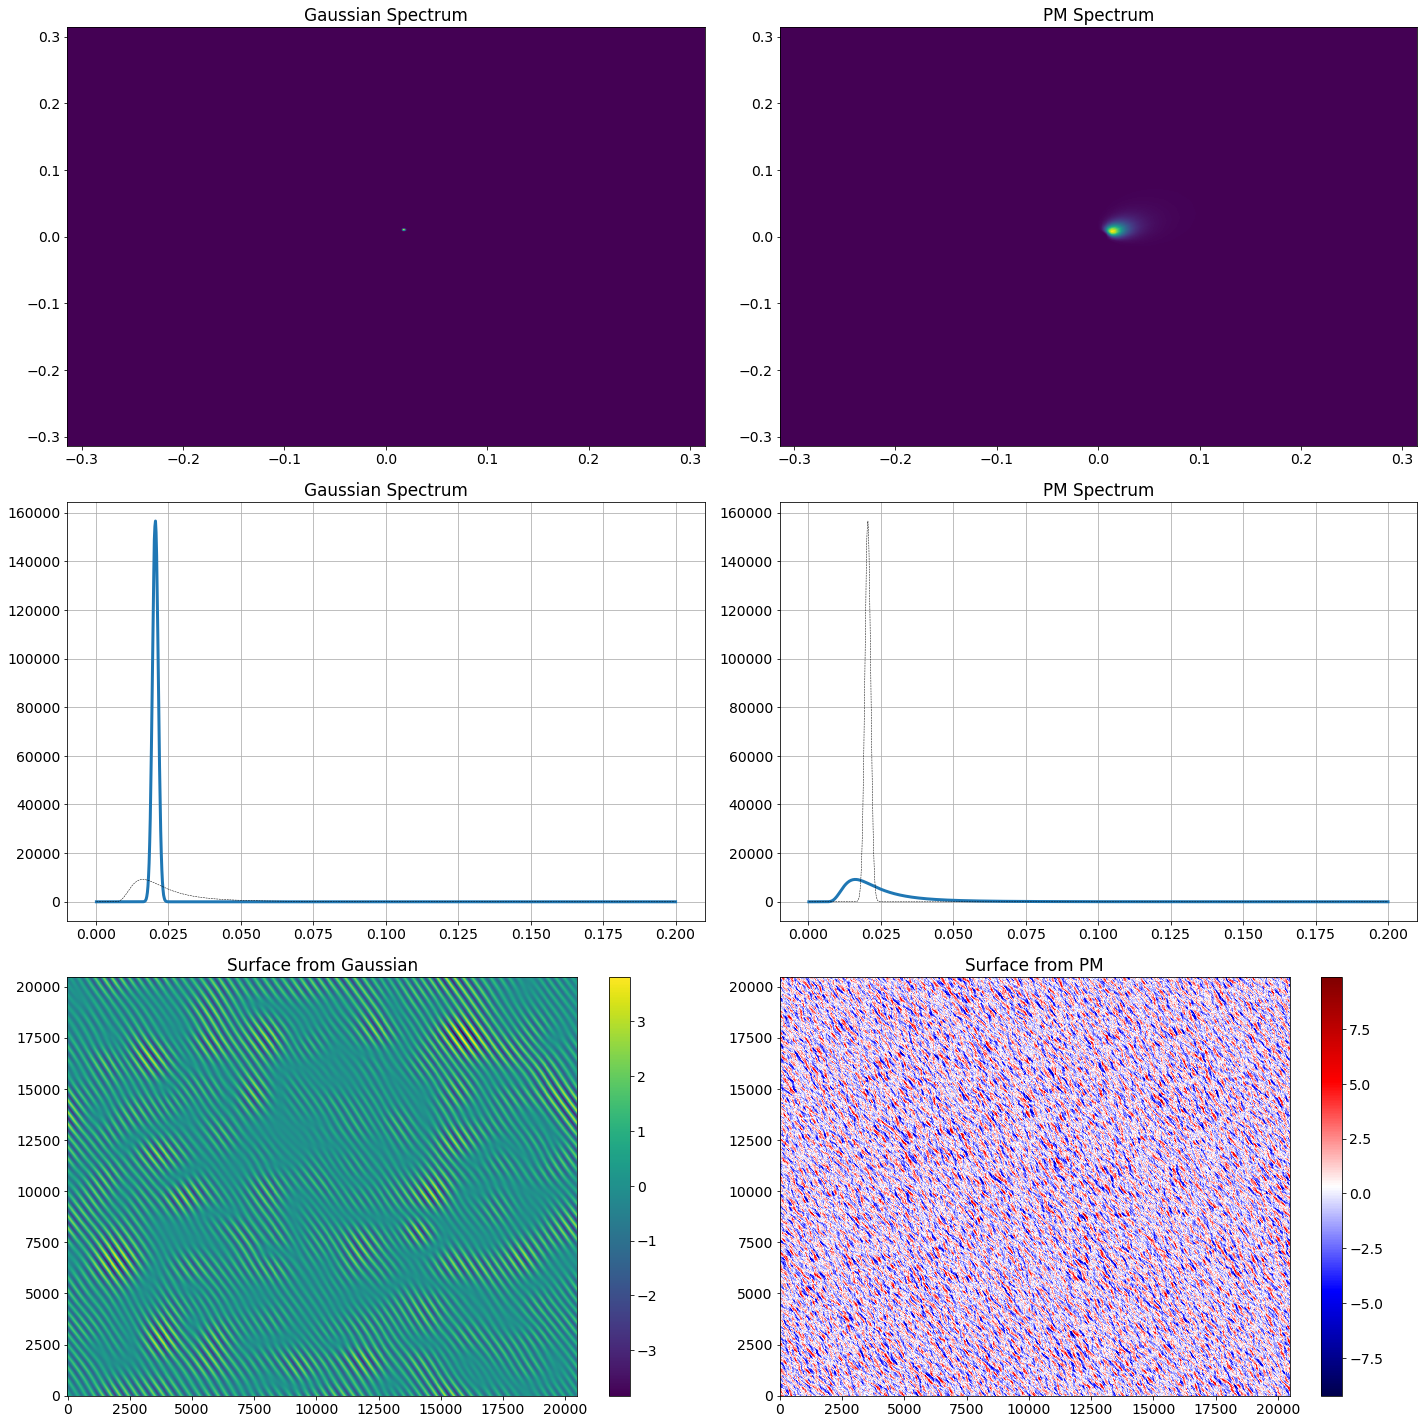

In [3]:
# OLD VERSION
# X, Y : grid of wavenumbers = 2 * pi /wavelength
# steps : dkx and dky, with nx and ny values. dkx = 2*pi/(dx*nx)
# x, y : grid of real x,y : nx values with a dx step. 
noise= 0
## ---  physical surface definition
# number of x values
nx = 2048
ny = 2048
dx = 10 # [m]
dy = 10 # [m]

# X = np.arange(0,nx*dx,dx) # from 0 to (nx-1)*dx with a dx step
# Y = np.arange(0,ny*dy,dy) # from 0 to (ny-1)*dy with a dy step
## --- equivalent wavenumber space ----
dkx = 2*np.pi/(dx*nx)
dky = 2*np.pi/(dy*ny)

kX0 = dkx*np.arange(-nx//2+1,nx//2+1)
kY0 = dky*np.arange(-ny//2+1,ny//2+1)
kX,kY = np.meshgrid(kX0, kY0)

## --- read_spectra
theta_m=30
D=1000
T0=14
Hs = 15

## --- 1. Gaussian -------
sk_theta = 0.001
sk_k = 0.001
Z1_Gaussian0,kX,kY=define_Gaussian_spectrum_kxky(kX,kY,T0,theta_m*np.pi/180,sk_theta,sk_k,D=D)
# Z1_Gaussian =(Hs/4)**2*Z1_Gaussian0
Z1_Gaussian =Z1_Gaussian0
sumZ1=4*np.sqrt(sum(Z1_Gaussian.flatten()*dkx*dky)) 
print('Hs for Gaussian : ',sumZ1)

## --- 2. Pierson - Moskowitz -----------------------------
nk=1001
nth=36
k=np.linspace(0.0002,0.2,nk)
thetas=np.linspace(0,360*(nth-1)/nth,nth)*np.pi/180.

Ekth,k,th = define_spectrum_PM_cos2n(k,thetas,T0,theta_m*np.pi/180.,D=D)
Ekxky, kx, ky = spectrum_to_kxky(1,Ekth,k,thetas,D=D)

Z1_PM=spi.griddata((kx.flatten(),ky.flatten()),Ekxky.flatten(),(kX,kY),fill_value=0)
sumZ1=4*np.sqrt(sum(Z1_PM.flatten()*dkx*dky)) 
print('Hs for Pierson Moskowitz : ',sumZ1)

## ----- Extract k spectrum in theta_m direction ----------
kx_vec = k*np.cos(theta_m*np.pi/180)
ky_vec = k*np.sin(theta_m*np.pi/180)

Z1k_PM = spi.griddata((kx.flatten(),ky.flatten()),Ekxky.flatten(),(kx_vec,ky_vec),fill_value=0)

f = spi.interp2d(kX0,kY0,Z1_Gaussian)
Z1k_Gaussian = np.diag(f(kx_vec,ky_vec))

## ----- Obtain surface ----------------------------------
S1_Gaussian,X,Y= surface_from_Z1kxky(Z1_Gaussian,kX,kY)
S1_PM,X,Y= surface_from_Z1kxky(Z1_PM,kX,kY)


## ----- Draw figure -------------------------------------
fig,axs=plt.subplots(3,2,figsize=(20,20))#,sharey=True,sharex=True)
print(Z1_Gaussian.max())
print(Z1_Gaussian.min())
axs[0][0].pcolormesh(kX,kY,Z1_Gaussian)
axs[0][0].set_title('Gaussian Spectrum')

axs[0][1].pcolormesh(kX,kY,Z1_PM)
axs[0][1].set_title('PM Spectrum')

axs[1][0].plot(k,Z1k_Gaussian,linewidth=3)
axs[1][0].plot(k,Z1k_PM,'--k',linewidth=0.5)
axs[1][0].grid(True)
axs[1][0].set_title('Gaussian Spectrum')

axs[1][1].plot(k,Z1k_PM,linewidth=3)
axs[1][1].plot(k,Z1k_Gaussian,'--k',linewidth=0.5)
axs[1][1].grid(True)
axs[1][1].set_title('PM Spectrum')

im=axs[2][0].pcolormesh(X,Y,S1_Gaussian,cmap='viridis',norm = mcolors.Normalize(vmin=S1_Gaussian.min(), vmax=S1_Gaussian.max()))
axs[2][0].set_title('Surface from Gaussian')
_=plt.colorbar(im,ax=axs[2][0])

im=axs[2][1].pcolormesh(X,Y,S1_PM,cmap='seismic',norm = mcolors.Normalize(vmin=S1_PM.min(), vmax=S1_PM.max()))
axs[2][1].set_title('Surface from PM')
_=plt.colorbar(im,ax=axs[2][1])
plt.tight_layout()

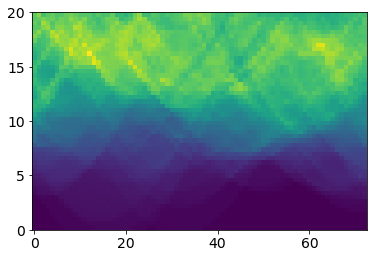

In [70]:
plt.figure()
plt.pcolormesh(np.arange(nsamp),edges[:-1]+0.5*dr,waveforms.T)


In [10]:
A=np.linspace(0,20,51)
dr=A[1]-A[0]

B=np.arange(0,20+dr,dr)
print(A.shape)
print(B.shape)

(51,)
(51,)


In [55]:
print(r[np.isfinite(r)].max())
print(r[np.isfinite(r)].min())

560024.202695912
559989.8799936043


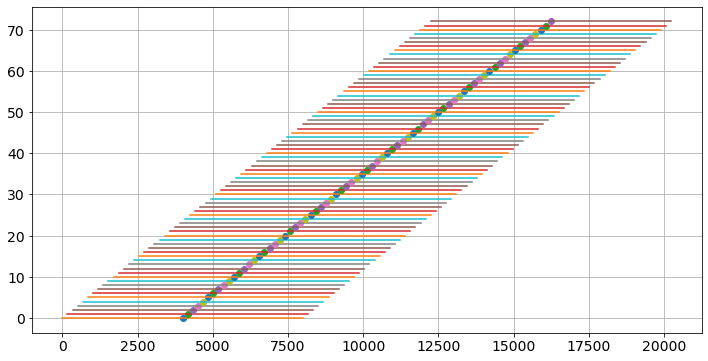

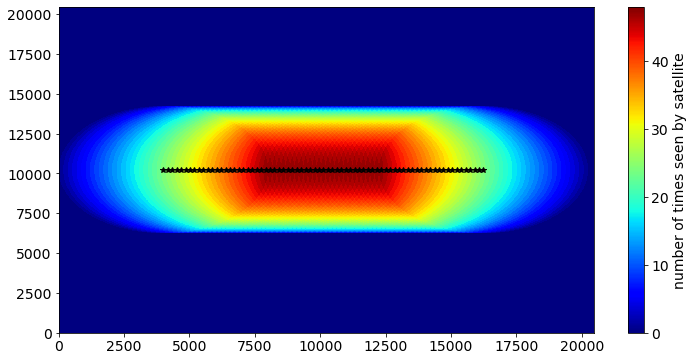

In [41]:
## ----- investigate overlapping ---------------------------
plt.figure(figsize=(12,6))
for isamp in range(nsamp):
    ialt=(nxa+isamp*di).astype(int)
    Xalt = X[ialt]
    Xalt_rad = X[ialt-nxa:ialt+nxa+1]
    plt.plot(Xalt,isamp,'o')
    plt.plot(Xalt_rad,isamp*np.ones(Xalt_rad.shape),'-')
plt.grid(True)

nb_times_seen = np.zeros(S1_Gaussian.shape)
for isamp in range(nsamp):
    ialt=(nxa+isamp*di).astype(int)
    Xalt = X[ialt]
    nb_times_seen[ialt-nxa:ialt+nxa+1,ny_mid-nxa:ny_mid+nxa+1] = nb_times_seen[ialt-nxa:ialt+nxa+1,ny_mid-nxa:ny_mid+nxa+1] +footprint

plt.figure(figsize=(12,6))
im=plt.pcolormesh(X,Y,nb_times_seen.T,cmap='jet')
plt.colorbar(im,label='number of times seen by satellite')
Yalt=Y[ny_mid]
for isamp in range(nsamp):
    ialt=(nxa+isamp*di).astype(int)
    Xalt = X[ialt]
    plt.plot(Xalt,Yalt,'*k')

In [76]:
## ---- print some dimensions and values to investigate links ---------------
# N.B.: easier with nx != ny
print('nx, ny = ',nx,' , ',ny)
print('X, Y = ',np.shape(X),' , ',np.shape(Y))
print('maxX, maxY = ',X.max(),' , ',Y.max())
print('kX0, kY0 = ',np.shape(np.unique(kX)),' , ',np.shape(kY0))
print('kX, kY = ',np.shape(kX),' , ',np.shape(kY))
print('shape Z1 = ',np.shape(Z1_PM))
print('shape rg =  ',np.shape(rg))#,' , ',np.shape(dky))
# ny = Z1.shape[0]
# nx = Z1.shape[1]
print('dkx = ',dkx,' =?= ',kX0[1] - kX0[0])
print('dx = ',dx,' =?= ',np.floor(2*np.pi/((kX0[1] - kX0[0])*nx)))
dx2 = (2*np.pi/((kX0[1] - kX0[0])*nx))
print('dkx = ',dkx,' =?= ',kX0[1] - kX0[0],' =?= ',2*np.pi/(dx2*nx))
print(kp)

nx, ny =  2048  ,  2048
X, Y =  (2048,)  ,  (2048,)
maxX, maxY =  20470  ,  20470
kX0, kY0 =  (2048,)  ,  (2048,)
kX, kY =  (2048, 2048)  ,  (2048, 2048)
shape Z1 =  (2048, 2048)
shape rg =   (2048, 2048)
dkx =  0.00030679615757712823  =?=  0.0003067961575771161
dx =  10  =?=  10.0
dkx =  0.00030679615757712823  =?=  0.0003067961575771161  =?=  0.0003067961575771161
0.01006075885537153


kx2D[0,0]= 0.0
ky2D[0,0]= 0.0
1023.0


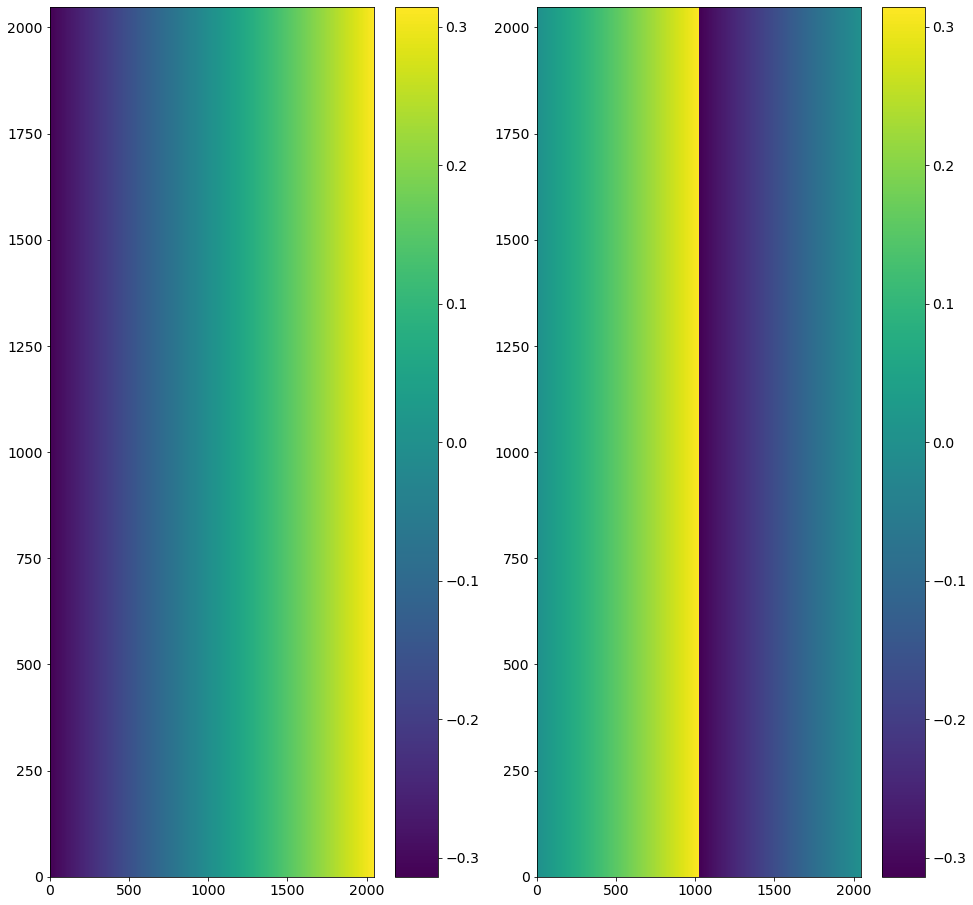

In [23]:
### ---- investigations on np.roll ------------------------------------
ky2D=np.roll(kY,(-int(shy),-int(shx)),axis=(0,1)) # checks that ky2D(1,1)=0 ... 
kx2D=np.roll(kX,(-int(shy),-int(shx)),axis=(0,1))# -int(shx),axis=1) # checks that kx2D(1,1)=0 ... 
print('kx2D[0,0]=',kx2D[0,0])
print('ky2D[0,0]=',ky2D[0,0])
print(shx)
fig,axs=plt.subplots(1,2,figsize=(16,8))

im=axs[0].pcolormesh(kX,cmap='viridis',norm = mcolors.Normalize(vmin=kX.min(), vmax=kX.max()))
plt.colorbar(im,ax=axs[0])

im=axs[1].pcolormesh(kx2D,cmap='viridis',norm = mcolors.Normalize(vmin=kx2D.min(), vmax=kx2D.max()))
plt.colorbar(im,ax=axs[1])

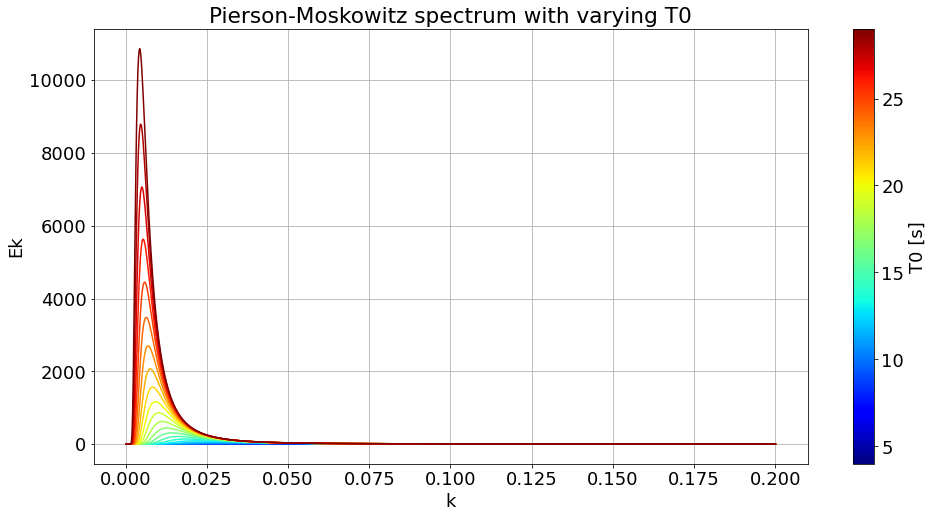

In [8]:
# ---------- Pierson Moskowitz Spectrum depending on T0 ------------

T0s = np.arange(4,30)
nk = 1001
k=np.linspace(0.0002,0.2,nk)

plt.figure(figsize=(16,8))
colors = plt.cm.jet(np.linspace(0,1,len(T0s)))
cNorm  = mcolors.Normalize(vmin=T0s[0], vmax=T0s[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='jet')
for iT0 in range(len(T0s)):
    Ek = PM_spectrum_k(k,1/T0s[iT0],D=D)
    _=plt.plot(k,Ek,'-',color=colors[iT0])
_=plt.grid(True)
_=plt.xlabel('k')
_=plt.ylabel('Ek')
_=plt.colorbar(scalarMap,label='T0 [s]')
_=plt.title('Pierson-Moskowitz spectrum with varying T0')

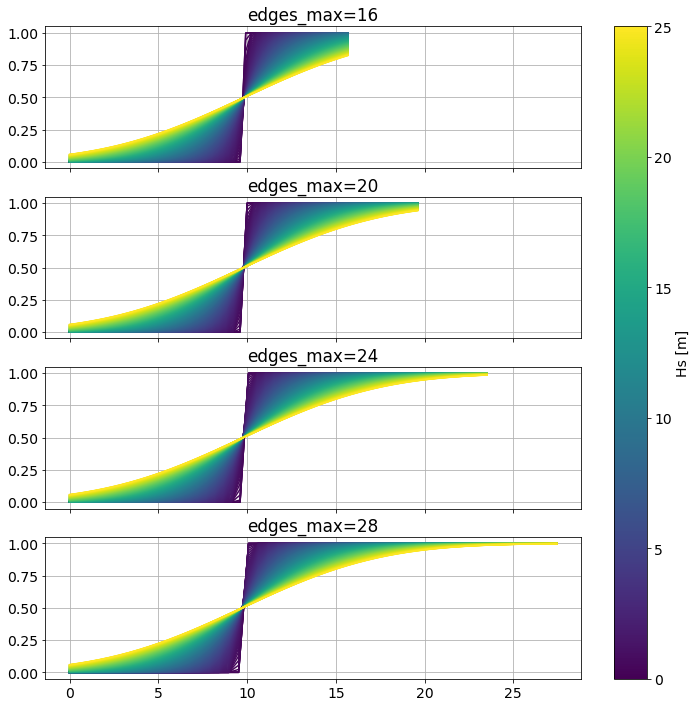

In [24]:
## ---- investigate differences in terms of edges.max() -------- 
colors = plt.cm.viridis(np.linspace(0,1,nHs))
cNorm  = mcolors.Normalize(vmin=Hsm.min(), vmax=Hsm.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis')

fig,axs=plt.subplots(4,1,figsize=(12,12),sharex=True)
for ned in range(4):
    wfm, Hsm, edges = generate_wvform_database(ne,nHs,edges_max=16+ned*4,Hs_max=25)
    for k in range(nHs):
        _=axs[ned].plot(edges[:-1],wfm[k,:],color=colors[k])
    tit = 'edges_max='+str(16+ned*4)
    axs[ned].set_title(tit)
    axs[ned].grid(True)

_=plt.grid(True)
_=plt.colorbar(scalarMap,label='Hs [m]',ax=axs[:])



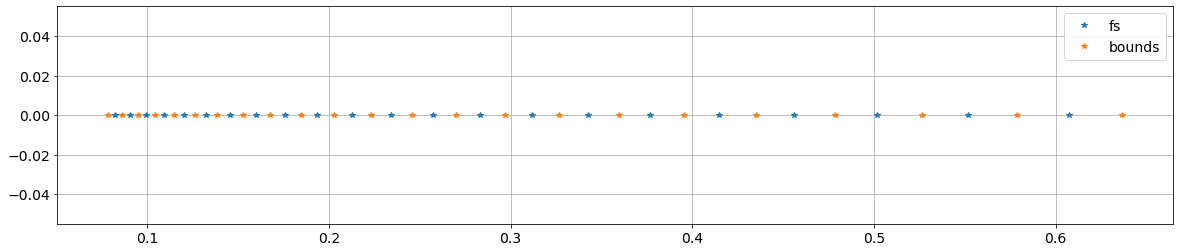

In [82]:
## --- geometrical expansion for frequency (microbaroms)
fo = 0.082038
xfr = 1.1
n = np.arange(0,22)
fn = fo *xfr**n
fn2 = np.zeros((len(fn)+1))
fn2[0] = fn[0]/np.sqrt(xfr)
fn2[1:] = fn * np.sqrt(xfr)
plt.figure(figsize=(20,4))
plt.plot(fn,np.zeros(fn.shape),'*',label='fs')
plt.plot(fn2,np.zeros(fn2.shape),'*',label='bounds')
plt.grid(True)
plt.legend()

In [4]:
## --- Read and investigate L1a data ---------------------
import xarray as xr
filenc='/home/datawork-cersat-public/provider/cnes/satellite/l1a/cfosat/swim/swi_l1a___/op05/5.1.2/2020/002/CFO_OP05_SWI_L1A____F_20200102T002637_20200102T020004.nc'
ds=xr.open_dataset(filenc,decode_times=False)
plt.plot(ds.isel(n_mcycles=15).radar_range_0,ds.isel(n_mcycles=15).echo_l1a_0,'.')
plt.grid(True)
ds

NameError: name 'plt' is not defined

In [5]:
ds

KeyboardInterrupt: 

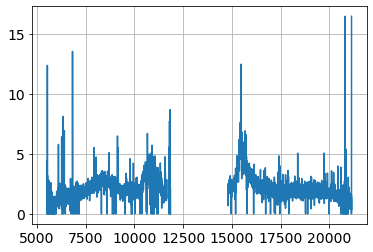

In [37]:
## ---- Read and investigate L2 data --------------------------
filenc='/home/datawork-cersat-public/provider/cnes/satellite/l2/cfosat/swim/swi_l2____/op05/5.1.2/2020/002/CFO_OP05_SWI_L2_____F_20200102T002637_20200102T020004.nc'
dsL2=xr.open_dataset(filenc,decode_times=False)
plt.plot(dsL2.nadir_swh_native,dsL2.nadir_swh_native)
plt.grid(True)

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
nbcycle = 16000
# plt.plot(np.diff(ds.isel(n_mcycles=nbcycle).radar_range_0))


plt.plot(ds.isel(n_mcycles=nbcycle).radar_range_0,ds.isel(n_mcycles=nbcycle).echo_l1a_0,'.')
plt.grid(True)
plt.figure()
plt.plot(ds.isel(n_mcycles=nbcycle).ground_range_0,ds.isel(n_mcycles=nbcycle).echo_l1a_0,'.')
plt.grid(True)
print(ds.isel(n_mcycles=nbcycle).ground_range_0.data)

plt.figure()
plt.plot(ds.isel(n_mcycles=nbcycle).echo_l1a_0,'.')
plt.grid(True)

plt.figure()
plt.plot(ds.isel(n_mcycles=nbcycle,n_beam0=0).echo_l1_0,'.')
plt.grid(True)

# dx = 0.374